# *Import Libraries*

In [1]:
import os
import cv2

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from skimage import feature, exposure

#np.random.seed(100)

%matplotlib inline

# *Load some extracted puzzle alphabets images*

In [2]:
img1 = cv2.imread("padded_chars/padded_puzzle_4/A (2).jpg", 0)
img2 = cv2.imread("padded_chars/padded_puzzle_8/E (2).jpg", 0)
img3 = cv2.imread("padded_chars/padded_puzzle_1/L.jpg", 0)
img4 = cv2.imread("padded_chars/padded_puzzle_2/B (3).jpg", 0)

In [3]:
# print their shape
img1.shape, img2.shape, img3.shape, img4.shape

((38, 40), (22, 16), (55, 55), (51, 37))

# *Visualize Images*

(-0.5, 37.5, 37.5, -0.5)

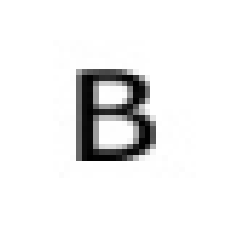

In [5]:
img4_resized = cv2.resize(img4, (38, 38), interpolation=cv2.INTER_AREA)
plt.imshow(img4_resized, cmap='gray')
plt.axis('off')

(-0.5, 39.5, 37.5, -0.5)

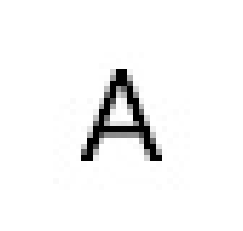

In [6]:
plt.imshow(img1, cmap='gray')
plt.axis('off')

(-0.5, 37.5, 37.5, -0.5)

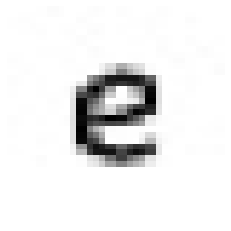

In [7]:
plt.imshow(cv2.resize(img2, (38, 38), interpolation=cv2.INTER_AREA), cmap='gray')
plt.axis('off')

(-0.5, 37.5, 37.5, -0.5)

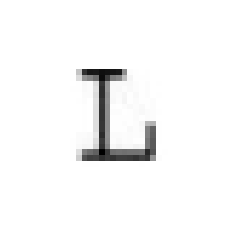

In [8]:
plt.imshow(cv2.resize(img3, (38, 38), interpolation=cv2.INTER_AREA), cmap='gray')
plt.axis('off')

In [9]:
def load_images_to_df(FOLDER_PATH=None):
    """
    Load all alphabets images, stack them together and convert them into a pandas DataFrame.
    Every image is reshaped to 1D (38*38)
    """
    features = []
    labels = []

    FOLDERS = os.listdir(FOLDER_PATH)

    for folder in FOLDERS:
        image_paths = os.listdir(FOLDER_PATH+"/"+folder)

        for img_path in image_paths:
            image_path = FOLDER_PATH+"/"+folder+"/"+img_path
            img = cv2.imread(image_path, 0)
            img = cv2.resize(img, (38, 38), interpolation=cv2.INTER_AREA)
            img = img.reshape(1, 38*38)

            features.append(img)
            labels.append(img_path.split(" ")[0].split(".")[0].strip())

    features_df = pd.DataFrame(np.concatenate(features))
    labels = np.array(labels).reshape(-1, 1)
    labels_df = pd.DataFrame(labels, columns=["targets"])

    data = pd.concat([features_df, labels_df], axis=1)
    return data
    


In [10]:
data = load_images_to_df(FOLDER_PATH="padded_chars")

<AxesSubplot:xlabel='targets', ylabel='count'>

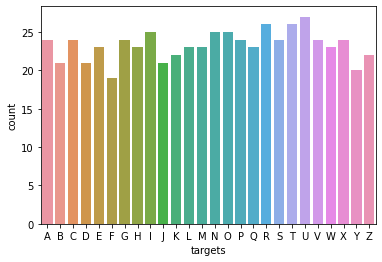

In [11]:
# check the distribution of the labels 
sns.countplot(x=data["targets"])

In [12]:
df = data.copy()
df = df.sample(frac=1).reset_index(drop=True)
df

,0,1,2,3,4,5,6,7,8,9,...,1435,1436,1437,1438,1439,1440,1441,1442,1443,targets
0,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,W
1,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,Y
2,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,Z
3,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,H
4,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,D
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
601,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,A
602,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,A
603,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,Z
604,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,C


# *Split Data*

In [13]:

X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, :-1], df["targets"], test_size=0.35, shuffle=True, random_state=100)

<AxesSubplot:xlabel='targets', ylabel='count'>

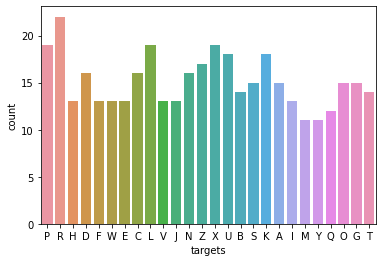

In [14]:
sns.countplot(x=y_train)

<AxesSubplot:xlabel='targets', ylabel='count'>

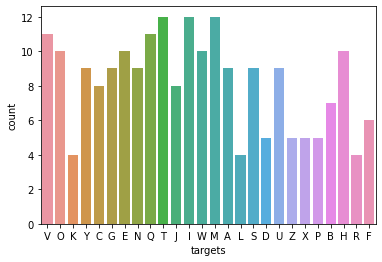

In [15]:
sns.countplot(x=y_test)

In [16]:
X_train.shape, X_test.shape

((393, 1444), (213, 1444))

# *Baseline Model*

In [17]:
svm = SVC()
svm.fit(X_train, y_train)

svm_preds = svm.predict(X_test)
accuracy = f1_score(y_test, svm_preds, average="weighted")
print(f"Accuracy: {accuracy}")

Accuracy: 0.8260919577678093


In [18]:
lgb = LGBMClassifier()
lgb.fit(X_train, y_train)
lgb_preds = lgb.predict(X_test)
accuracy = f1_score(y_test, lgb_preds, average="weighted")
print(f"Accuracy: {accuracy}")

Accuracy: 0.8488560764887456


# *Dimentionality Reduction*

In [19]:
pca = PCA()

pca.fit(X_train)

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
pca

PCA()

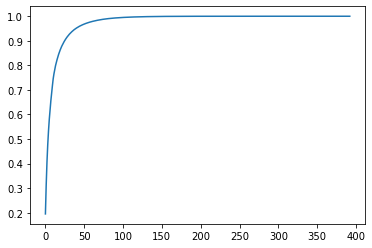

In [20]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))

In [21]:
svm = SVC()
svm.fit(X_train_pca, y_train)

svm_preds = svm.predict(X_test_pca)
accuracy = f1_score(y_test, svm_preds, average="weighted")
print(f"Accuracy: {accuracy}")

Accuracy: 0.8817459622805156


In [22]:
lgb = LGBMClassifier()
lgb.fit(X_train_pca, y_train)
lgb_preds = lgb.predict(X_test_pca)
accuracy = f1_score(y_test, lgb_preds, average="weighted")
print(f"Accuracy: {accuracy}")

Accuracy: 0.8736331706774433


# *Feature extraction - Histogram of Orientation Gradient*

In [23]:
def image_2d(data):
    data_2d = []
    for img in data.values:
        data_2d.append(img.reshape(38, 38))
    data_2d = np.stack(data_2d)
    return data_2d

def hog_features(img_data):
    hog = []
    for img in img_data:
        h=feature.hog(data.astype("uint8"), orientations=8, pixels_per_cell=(10, 10),
		cells_per_block=(2, 2), transform_sqrt=True, block_norm="L1")
        hog.append(h.reshape(1, -1))
    return np.stack(hog)

In [24]:
# X_train_2d = image_2d(X_train)
# X_test_2d = image_2d(X_test)

# X_train_hog = hog_features(X_train_2d)
# X_test_hog = hog_features(X_test_2d)

# svm = SVC()
# svm.fit(X_train_hog.reshape(-1, 128), y_train)

# svm_preds = svm.predict(X_test_hog.reshape(-1, 128))
# accuracy = f1_score(y_test, svm_preds, average="weighted")
# print(f"Accuracy: {accuracy}")

In [27]:
# # visualize the HOG image
# hogImage = exposure.rescale_intensity(hogImage, out_range=(0, 255))
# hogImage = hogImage.astype("uint8")
# cv2.imshow("HOG Image #{}".format(i + 1), hogImage)

# *Serialize Model*

In [28]:
import pickle
pickle.dump(svm, open("SVMclassify.pkl", "wb"))
pickle.dump(pca, open("PCA.pkl", "wb"))